# Chaos in Periodically-Driven Systems

## KR1: RK-4 Scheme

### Preliminary

- Call .jl file containing modules with functions. 
- Import necessary packages.

In [8]:
using BenchmarkTools
using Plots
using FFTW
using DelimitedFiles

include("spinning_compass_functions.jl");

## Implementation

- Use `help` to obtain doc string of RK-4 numerical integrator function.

In [9]:
? Spin_compass.RK4()

```
RK4(eom_func, t_param, r)
```

Solve systems of first-order ordinary differential equations using the fourth-order Runge-Kutta method.

# Args

  * eom*func (Function): function corresponding to the equations of motion to be integrated. The function must follow the format: `eom*func(r, t)`.
  * time*param (Tuple): initial and final time, and number of steps of the integration. `time*param`must follow the format:`time*param = [t*initial, t_final, Npoints]`
  * r (Array): initial state of the system. r must follow the same ordering of variables used in `eom_func`.

# Returns

  * (tpoints, xpoints, vpoints): Arrays containing the IVP solution of the EOM


The above doc string demonstrates we have written a Julia function that implements the RK-4 algorithm.

## Equations of Motion
- Implement functions for the motion of spinning magnet 
$$\frac{d^2}{dt^2}\phi = -\frac{\mu}{I}B_0 \cos(\omega t)\sin\phi$$
- Benchmark EOM functions.

### EOM Functions

We wrote to Julia functions for the EOM: 1) the EOM as expressed by the equation provied and 2) a dimensionelss version of it. Refer to the .jl file lines 11-33 and lines 36-57, respectively.

In [10]:
? Spin_compass.EOM_compass()

EOM_compass(r, t, B, ω)

# Description

Equations of motion for a spinning compass in a periodically changing magnetic field

# Args

```
r (Array): Array containing the compass' state at time t. `r` must have the form: `r = [x, v]`
t (Float64): time t.
B (Float64): non-dimensional magnetic field amplitude
ω (Float64): non-dimensional driving frequency
```

# Returns

```
[dxdt, dvdt] (Array): system's velocity state at t.
```


In [11]:
? Spin_compass.EOM_compass_unitless()

EOM*compass*unitless(r, t, λ)

# Description

Unitless equations of motions of the periodically-driven spinning compass. 

The time variable is expressed in terms of the driving period `T = ωt``. For the simulation time to be commensurate with the driving period, set T_f =`2πn`

# Args

```
r (Array): Array containing the compass' state at time t. `r` must have the form: `r = [x, v]`
t (Float64): time t
λ (Float64): unitless amplitude
```

# Returns

```
[dxdt, dvdt] (Array): system's velocity state at t.
```


### Benchmark
- Use `@code_warntype` to check type stability
- Use `@benchmark` to benchmark Julia functions of the EOM

In [32]:
# Function parameters
B = rand();
ω = rand();
drive_period = 2π / ω;

# Simulation parameters
t_initial, t_final = 0.0, 100*drive_period;
Nsteps = 10000;
time_param = (t_initial, t_final, Nsteps);

# Initial conditions
x0, v0 = rand(), rand();
r = [x0, v0];

In [33]:
@code_warntype Spin_compass.EOM_compass(r,t_final,B,ω)

MethodInstance for Main.Spin_compass.EOM_compass(::Vector{Float64}, ::Float64, ::Float64, ::Float64)
  from EOM_compass(r::Array, t::Float64, B::Float64, ω::Float64) @ Main.Spin_compass D:\Physics 215\Mini Project\spinning-compass\spinning_compass_functions.jl:28
Arguments
  #self#::Core.Const(Main.Spin_compass.EOM_compass)
  r::Vector{Float64}
  t::Float64
  B::Float64
  ω::Float64
Locals
  @_6::Int64
  dvdt::Float64
  dxdt::Float64
  v::Float64
  x::Float64
Body::Vector{Float64}
1 ─ %1  = Base.indexed_iterate(r, 1)::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(2)])
│         (x = Core.getfield(%1, 1))
│         (@_6 = Core.getfield(%1, 2))
│   %4  = Base.indexed_iterate(r, 2, @_6::Core.Const(2))::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(3)])
│         (v = Core.getfield(%4, 1))
│         (dxdt = v)
│   %7  = -B::Float64
│   %8  = (ω * t)::Float64
│   %9  = Main.Spin_compass.cos(%8)::Float64
│   %10 = Main.Spin_compass.sin(x)::Float64
│   

In [34]:
@benchmark Spin_compass.EOM_compass($r,$t_final,$B,$ω)

BenchmarkTools.Trial: 10000 samples with 991 evaluations.
 Range (min … max):  43.592 ns …   3.839 μs  ┊ GC (min … max):  0.00% … 97.98%
 Time  (median):     47.124 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   56.424 ns ± 139.298 ns  ┊ GC (mean ± σ):  10.07% ±  4.04%

  ▆█▆▄▆▆▄▂▃▄▅▄▃▃▄▃▂▂▂▂▂▁             ▂▂▂▂▁▁                    ▂
  ███████████████████████████████▇▇▇████████▇▇▇▆▇▇▆▆▆▆▅▆▅▁▅▆▅▆ █
  43.6 ns       Histogram: log(frequency) by time      91.5 ns <

 Memory estimate: 80 bytes, allocs estimate: 1.

In [35]:
λ = sqrt(B / ω^2);

In [36]:
@code_warntype Spin_compass.EOM_compass_unitless(r,t_final,λ)

MethodInstance for Main.Spin_compass.EOM_compass_unitless(::Vector{Float64}, ::Float64, ::Float64)
  from EOM_compass_unitless(r::Array, t::Float64, λ::Float64) @ Main.Spin_compass D:\Physics 215\Mini Project\spinning-compass\spinning_compass_functions.jl:52
Arguments
  #self#::Core.Const(Main.Spin_compass.EOM_compass_unitless)
  r::Vector{Float64}
  t::Float64
  λ::Float64
Locals
  @_5::Int64
  dvdT::Float64
  dxdT::Float64
  v::Float64
  x::Float64
Body::Vector{Float64}
1 ─ %1  = Base.indexed_iterate(r, 1)::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(2)])
│         (x = Core.getfield(%1, 1))
│         (@_5 = Core.getfield(%1, 2))
│   %4  = Base.indexed_iterate(r, 2, @_5::Core.Const(2))::Core.PartialStruct(Tuple{Float64, Int64}, Any[Float64, Core.Const(3)])
│         (v = Core.getfield(%4, 1))
│         (dxdT = v)
│   %7  = Main.Spin_compass.:^::Core.Const(^)
│   %8  = Core.apply_type(Base.Val, 2)::Core.Const(Val{2})
│   %9  = (%8)()::Core.Const(Val{2}())
│   %10

In [37]:
@benchmark Spin_compass.EOM_compass_unitless($r,$t_final,$λ)

BenchmarkTools.Trial: 10000 samples with 993 evaluations.
 Range (min … max):  40.181 ns …   4.229 μs  ┊ GC (min … max):  0.00% … 98.29%
 Time  (median):     45.619 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   55.079 ns ± 137.175 ns  ┊ GC (mean ± σ):  10.10% ±  4.03%

  ▇█▇▆▇▅▄▆▆▆▅▄▄▃▂▂▂▂▁▁▂▁▁▁     ▁▁▁▁▁▁                          ▂
  █████████████████████████████████████▇▇▇█▇▇▆▆▅▇▇▅▇▅▆▆▆▄▅▅▆▅▅ █
  40.2 ns       Histogram: log(frequency) by time       102 ns <

 Memory estimate: 80 bytes, allocs estimate: 1.

## KR2: Poincare Map
- Constructed a Poincare Map

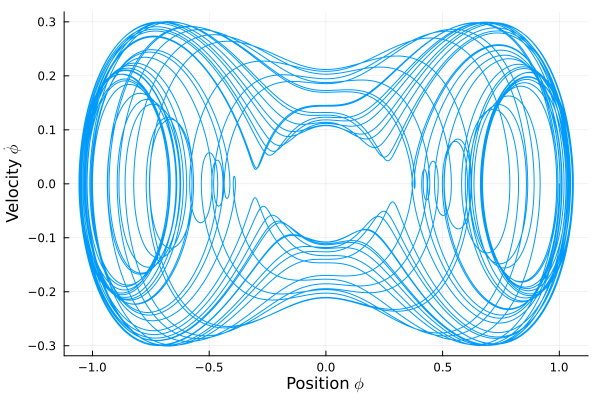

In [38]:
# Function parameters
B = 0.3
ω = 1.0
drive_period = 2*π / ω
f(r, t) = Spin_compass.EOM_compass(r, t, B, ω)

# Simulation parameters
t_initial, t_final = 0.0, 100*drive_period
Nsteps = 20000
time_param = (t_initial, t_final, Nsteps)

# Initial conditions
x0, v0 = 1.0, 0.0
r = [x0, v0]


(tpoints, xpoints, vpoints) = Spin_compass.RK4(f, time_param, r)

plot(xpoints, vpoints, label="")

ylabel!(raw"Velocity $\dot\phi$")
xlabel!(raw"Position $\phi$")

## KR3: $B_0 - \omega$ Phase Diagram
- Create Julia function for calculating spectral entropy.
- Benchmark aforementioned function.
- Construct $B_0 - \omega$ Phase Diagram 

## Spentral Entropy Function

In [40]:
? Phase_diagram.b_omega_spectral_diagram_scanner() 

b*omega*spectral*diagram*scanner(time*param, scan*param)

# Description

Generates a 2D array with size (resolution , resolution) containing the spectral entropy of the spin compass'  dynamics as a function of both B and ω for a given range set by the `scan_param` input.

## Args

```
scan_param (Tuple{Float64, Float64, Float64, Float64, Int64}): range of lambda to be considered and the resolution of 
    the scan. `scan_param` must follow the format: 
    'scan_param = [B_initial, B_final, omega_initial, omega_final, resolution]'
```

## Returns

```
spectral_entropy_diagram (Array): 2D array containing the spectral entropy as a function of B and ω
```


In [39]:
? Phase_diagram.b_omega_spectral_diagram_scan_saver() 

b*omega*spectral*diagram*scan_saver()

# Description

Generates and saves the matrix containing the spectral entropy information as a function of B and ω information a txt file.

## Args

```
scan_param (Tuple{Float64, Float64, Float64, Float64, Int64}): range of lambda to be considered and the resolution of 
    the scan. `scan_param` must follow the format: 
    'scan_param = [B_initial, B_final, omega_initial, omega_final, resolution]'

save_filename (String): filename of the txt file where the spectral entropy diagram will be saved
```

## Returns

```
A txt file containing the spectral entropy diagram as a function of B and ω for the given range set by scan_param.
```


## KR4: Chaotic Dynamics (Verification)